<a href="https://colab.research.google.com/github/s-mostafa-a/lung-cancer-segmentation/blob/master/using_wolny_package_for_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
def _cn_t_d():
  from google.colab import drive
  drive.mount("/content/drive")

In [2]:
def _untar_data():
  !tar -xf ./drive/My\ Drive/Copy_Task06_Lung.tar -C ./

In [3]:
def connect_to_drive():
  !mkdir drive
  _cn_t_d()
  _untar_data()

In [4]:
def install_all_needed_packages():
  !pip install git+git://github.com/s-mostafa-a/niftidataset.git
  !git clone https://github.com/wolny/pytorch-3dunet.git
  !pip install hdbscan
  !mv ./pytorch-3dunet ./p3dun

In [7]:
def make_databunch():
  np.random.seed(1)
  train_dir = '/content/Task06_Lung/'
  tfms = tvt.Compose([ToTensor(), RandomCrop3D(110), TrimIntensity(-1000.0,1000.0,0.0,255.0), Normalize(is_3d=True)])
  tds, vds = train_val_split(source_dir=train_dir+'imagesTr', target_dir=train_dir+'labelsTr', valid_pct=0.2, transform=tfms)
  print(len(tds), len(vds))
  idb = faiv.ImageDataBunch.create(tds, vds, bs=1, num_workers=1)
  return idb

In [8]:
def make_learner(idb):
  model = UNet3D(in_channels=1, out_channels=1, final_sigmoid=True)
  metric = metrics.DiceCoefficient()
  metric.__name__ = 'DiceCoefficient'
  learner = faiv.Learner(idb, model, loss_func=losses.BCEDiceLoss(alpha=0.3, beta=0.7), metrics=[metric], opt_func=torch.optim.Adam)
  return learner


In [ ]:
connect_to_drive()
install_all_needed_packages()

In [9]:
import numpy as np
import os
import sys
module_path = os.path.abspath(os.path.join('./p3dun/'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [10]:
from p3dun.pytorch3dunet.unet3d.model import UNet3D, ResidualUNet3D
from pytorch3dunet.unet3d import losses
from pytorch3dunet.unet3d import metrics
from niftidataset import NiftiDataset, train_val_split, RandomCrop3D, ToTensor, Normalize, TrimIntensity
from torchvision import transforms as tvt
from torch.nn import BCEWithLogitsLoss
import torch 
from fastai import vision as faiv
%matplotlib inline
%load_ext autoreload
%autoreload 2
!export CUDA_LAUNCH_BLOCKING=1

Because 3d image size are in like this: (512,512,z) which z range is from 112 to 465, I thougth it would be good if I crop each 3D image from it's third axis (z) and fix that in a constant like 110. This way raw data loss becomes so little. for example if we have an image sized (512,512, 112) we would generate an image (512,512,110), Also if we had an image sized (512, 512, 373) we would generate 3 images with sizes (512,512,110) which it covers 330 out of 373 from z of original raw data.

But when I used it with size (512,512,110), cuda went out of memory and it needed more RAM. Also I found some paper which they cropped this dataset's images to size (64,64,64)! which I thought their data loss would be so high. But anyway I went a way similar to their way and cropped original images to the size (110,110,110) which almost contains 8 times more data (and less data loss) from that paper.

So I wrote below classes which use some features of [this code](https://github.com/jcreinhold/niftidataset). It used a single image 5 times and cropped each randomly, but I thought It will not be useful because np.random.seed() makes each time just one crop. officially it wouldn't help.


In [ ]:
from typing import Callable, List, Optional
import nibabel as nib
import numpy as np
from PIL import Image
from torch.utils.data.dataset import Dataset
from glob import glob

def glob_imgs(path: str, ext='*.nii*') -> List[str]:
    """ grab all `ext` files in a directory and sort them for consistency """
    fns = sorted(glob(os.path.join(path, ext)))
    return fns

class ChangedNiftiDataset(Dataset):
    """
    create a dataset class in PyTorch for reading NIfTI files

    Args:
        source_fns (List[str]): list of paths to source images
        target_fns (List[str]): list of paths to target images
        transform (Callable): transform to apply to both source and target images
        preload (bool): load all data when initializing the dataset
    """

    def __init__(self, source_fns:List[str], target_fns:List[str], transform:Optional[Callable]=None, preload:bool=False):
        self.source_fns, self.target_fns = source_fns, target_fns
        self.transform = transform
        self.preload = True
        self.source_fns *= 5
        self.target_fns *= 5
        print(f'{self.source_fns}\n{self.target_fns}')
        self.imgs = [(nib.load(s).get_data(), nib.load(t).get_data())
                         for s, t in zip(self.source_fns, self.target_fns)]

    @classmethod
    def setup_from_dir(cls, source_dir:str, target_dir:str, transform:Optional[Callable]=None, preload:bool=False):
        source_fns, target_fns = glob_imgs(source_dir), glob_imgs(target_dir)
        return cls(source_fns, target_fns, transform, preload)

    def __len__(self):
        return len(self.source_fns)

    def __getitem__(self, idx:int):
        if not self.preload:
            src_fn, tgt_fn = self.source_fns[idx], self.target_fns[idx]
            sample = (nib.load(src_fn).get_fdata(dtype=np.float32), nib.load(tgt_fn).get_fdata(dtype=np.float32))
        else:
            sample = self.imgs[idx]
        if self.transform is not None:
            sample = self.transform(sample)
        return sample


def changed_train_val_split(source_dir:str, target_dir:str, valid_pct:float=0.2,
                    transform:Optional[Callable]=None, preload:bool=False):
    """
    create two separate NiftiDatasets in PyTorch for working with NifTi files. If a directory contains source files
    and the other one contains target files and also you dont have a specific directory for validation set,
    this function splits data to two NiftiDatasets randomly with given percentage.

    Args:
        source_dir (str): path to source images.
        target_dir (str): path to target images.
        valid_pct (float): percent of validation set from data.
        transform (Callable): transform to apply to both source and target images.
        preload: load all data when initializing the dataset
    Returns:
        Tuple: (train_dataset, validation_dataset).
    """
    if not (0 < valid_pct < 1):
        raise ValueError(f'valid_pct must be between 0 and 1')
    source_fns, target_fns = glob_imgs(source_dir), glob_imgs(target_dir)
    rand_idx = np.random.permutation(list(range(len(source_fns))))
    cut = int(valid_pct * len(source_fns))
    return (ChangedNiftiDataset(source_fns=[source_fns[i] for i in rand_idx[cut:]],
                         target_fns=[target_fns[i] for i in rand_idx[cut:]],
                         transform=transform, preload=preload),
            ChangedNiftiDataset(source_fns=[source_fns[i] for i in rand_idx[:cut]],
                         target_fns=[target_fns[i] for i in rand_idx[:cut]],
                         transform=transform, preload=preload))



In [ ]:
# np.random.seed(1)
# train_dir = '/content/Task06_Lung/'
# tfms = tvt.Compose([ToTensor(), Normalize()])
# tds, vds = changed_train_val_split(source_dir=train_dir+'imagesTr', target_dir=train_dir+'labelsTr', valid_pct=0.2, transform=tfms)

['/content/Task06_Lung/imagesTr/lung_053.nii.gz', '/content/Task06_Lung/imagesTr/lung_042.nii.gz', '/content/Task06_Lung/imagesTr/lung_083.nii.gz', '/content/Task06_Lung/imagesTr/lung_071.nii.gz', '/content/Task06_Lung/imagesTr/lung_005.nii.gz', '/content/Task06_Lung/imagesTr/lung_059.nii.gz', '/content/Task06_Lung/imagesTr/lung_054.nii.gz', '/content/Task06_Lung/imagesTr/lung_018.nii.gz', '/content/Task06_Lung/imagesTr/lung_081.nii.gz', '/content/Task06_Lung/imagesTr/lung_031.nii.gz', '/content/Task06_Lung/imagesTr/lung_051.nii.gz', '/content/Task06_Lung/imagesTr/lung_092.nii.gz', '/content/Task06_Lung/imagesTr/lung_028.nii.gz', '/content/Task06_Lung/imagesTr/lung_080.nii.gz', '/content/Task06_Lung/imagesTr/lung_078.nii.gz', '/content/Task06_Lung/imagesTr/lung_070.nii.gz', '/content/Task06_Lung/imagesTr/lung_049.nii.gz', '/content/Task06_Lung/imagesTr/lung_074.nii.gz', '/content/Task06_Lung/imagesTr/lung_047.nii.gz', '/content/Task06_Lung/imagesTr/lung_086.nii.gz', '/content/Task06_Lu

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


In [11]:
idb = make_databunch()
learner = make_learner(idb)


# learner.lr_find(start_lr=1e-10, end_lr=10)
# learner.recorder.plot()
# found that 1e+00 works fine

51 12


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


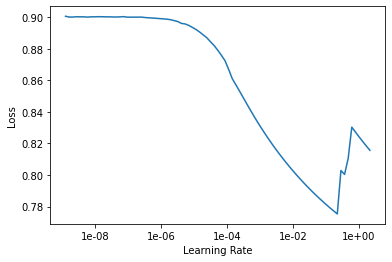

In [12]:
learner.lr_find(start_lr=1e-10, end_lr=10)
learner.recorder.plot()
# found that 1e+00 works fine

**Loading the model from drive:**

In [17]:
model_name = '3d_unet_model'

In [ ]:
!rm -r ./models
!mkdir ./models
!cp ./drive/My\ Drive/3d_unet_model.pth ./models/3d_unet_model.pth 

In [18]:
learner.load(model_name)

Learner(data=ImageDataBunch;

Train: <niftidataset.dataset.NiftiDataset object at 0x7fa7b41f8b70>;

Valid: <niftidataset.dataset.NiftiDataset object at 0x7fa7b41f8b00>;

Test: None, model=UNet3D(
  (encoders): ModuleList(
    (0): Encoder(
      (basic_module): DoubleConv(
        (SingleConv1): SingleConv(
          (groupnorm): GroupNorm(1, 1, eps=1e-05, affine=True)
          (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
        (SingleConv2): SingleConv(
          (groupnorm): GroupNorm(8, 32, eps=1e-05, affine=True)
          (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
      )
    )
    (1): Encoder(
      (pooling): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (basic_module): DoubleConv(
        (SingleConv1): SingleConv(
          (groupnorm): GroupNorm(

In [ ]:
learner.fit_one_cycle(10, max_lr=slice(1e-01), pct_start=0.5)

epoch,train_loss,valid_loss,DiceCoefficient,time
0,7.247751,2.610833,-0.000000,09:44


As mentioned in the paper [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/pdf/1706.05721.pdf), training process takes about 1000 epochs and best result is when beta equals to 0.7 (and alpha is 0.3).

**Saving model to drive:**

In [ ]:
learner.save(model_name)
learner.load(model_name)

In [ ]:
!cp ./models/3d_unet_model.pth ./drive/My\ Drive/3d_unet_model.pth